## Семинар 2 "Распознавание рукописных цифр"

ФИО: Кежаев Максим Константинович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

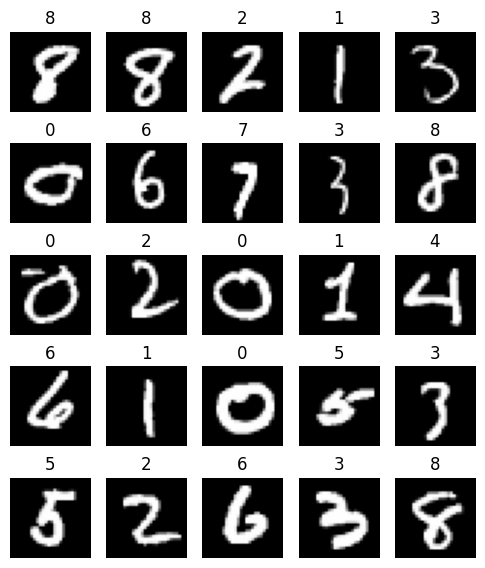

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [160]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None, train_loader=train_loader, test_loader=test_loader):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [84]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.302/0.295	Accuracy: 0.920/0.921

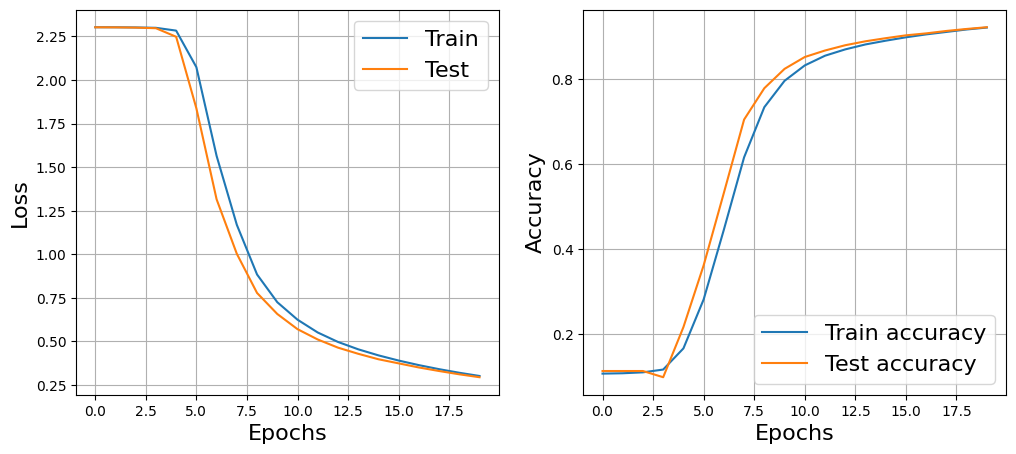

In [85]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [11]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [12]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.086	Accuracy: 0.990/0.975

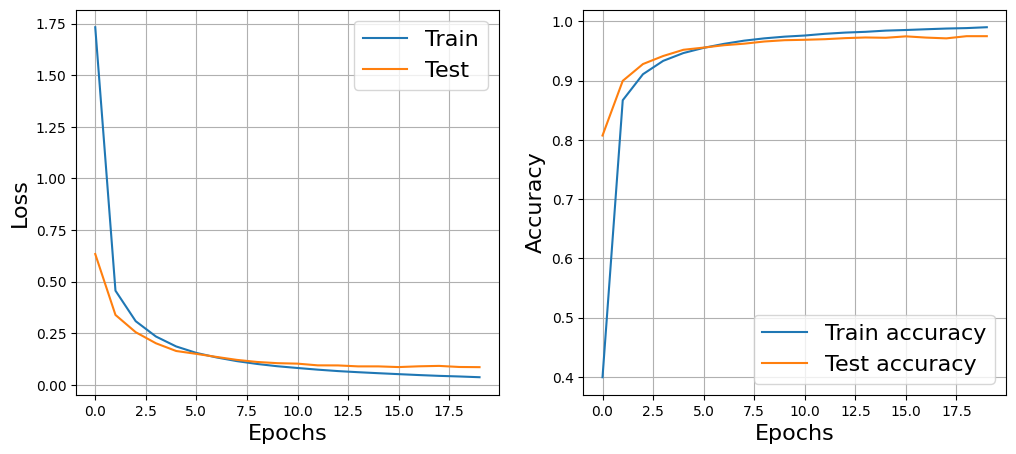

In [13]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.045/0.083	Accuracy: 0.987/0.975

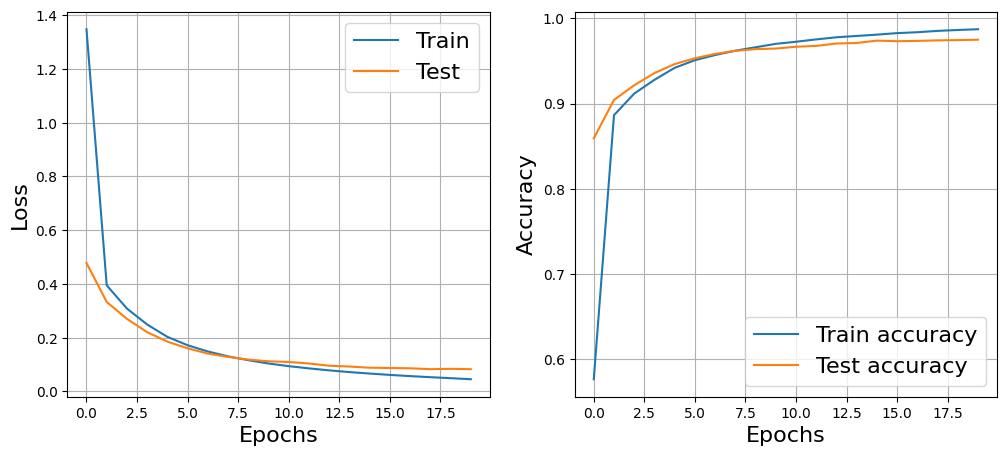

In [14]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### HW1 (1 балл): Реализовать Tanh

In [18]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        tanh(x) = (e^x - e^-x) / (e^x + e^-x)
        '''
        self.X = X
        self.tanh = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
        return self.tanh

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dLdx = (1 - self.tanh**2) * dLdy
        return dLdx

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.078	Accuracy: 0.994/0.976

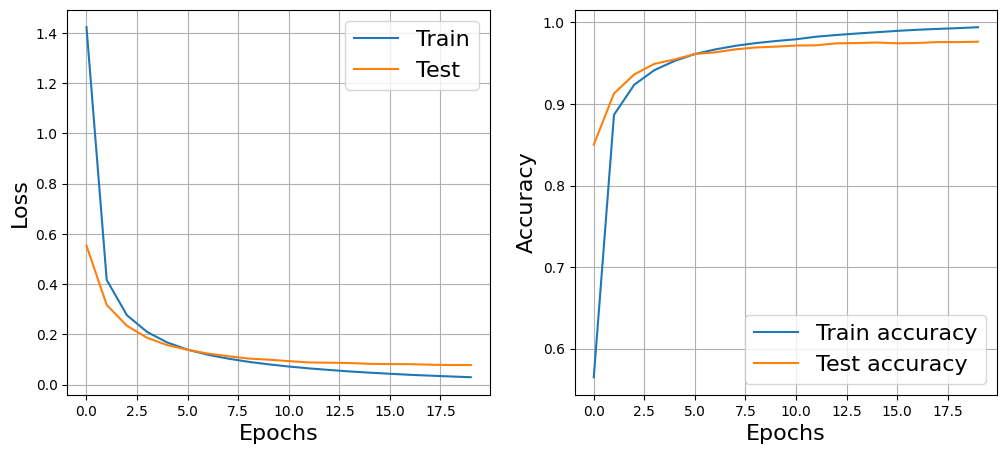

In [19]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_tg, ts_tg, tr_ac_tg, ts_ac_tg = train(network, 20, 0.01, plot=True, verbose=True)

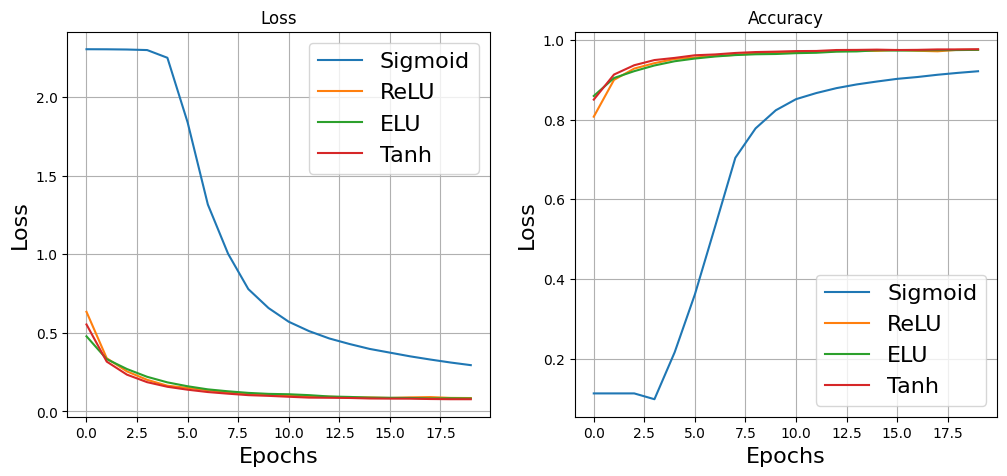

In [86]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_tg, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_tg, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [20]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

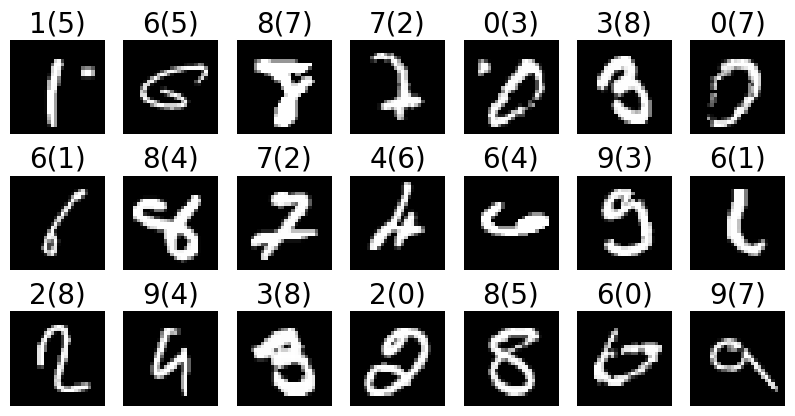

In [21]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

##### Отдельно рандомное вращение (-15, 15)

In [78]:
transform_r = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomRotation(degrees=(-15,15)),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_rotate = MNIST('.', train=True, download=True, transform=transform_r)
test_dataset_rotate = MNIST('.', train=False, transform=transform_r)

train_loader_rotate = DataLoader(train_dataset_rotate, batch_size=32, shuffle=True)
test_loader_rotate = DataLoader(test_dataset_rotate, batch_size=32, shuffle=False)

In [79]:
X_r, y_r = next(iter(train_loader_rotate))
X_r = X_r.numpy()
y_r = y_r.numpy()

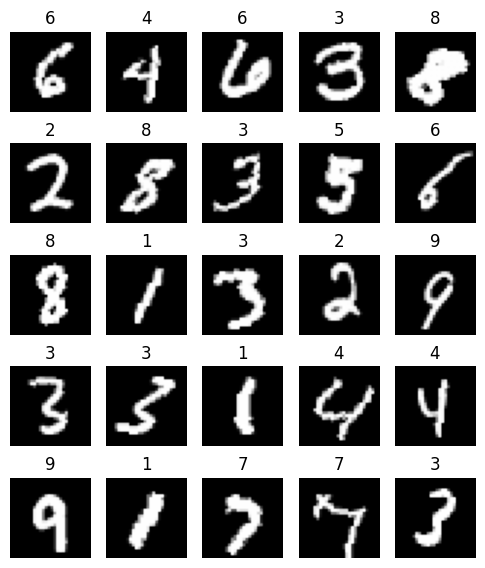

In [80]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_r[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y_r[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.068/0.087	Accuracy: 0.979/0.973

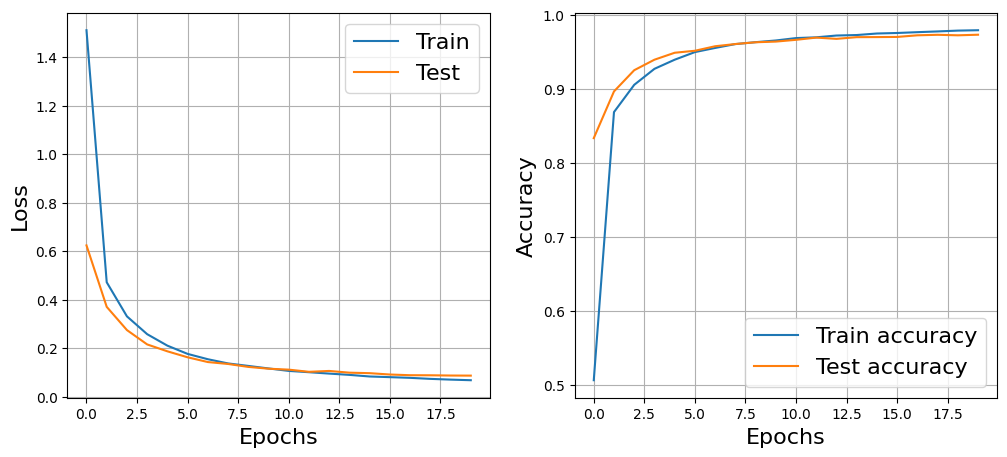

In [161]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_tg_rot, ts_tg_rot, tr_ac_tg_rot, ts_ac_tg_rot = train(network, 20, 0.01, plot=True, verbose=True, train_loader=train_loader_rotate, test_loader=test_loader_rotate)

##### Отдельно рандомные сдвиги

In [108]:
transform_shift = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomAffine(translate=(0.1, 0.3), degrees=0),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_shift = MNIST('.', train=True, download=True, transform=transform_shift)
test_dataset_shift = MNIST('.', train=False, transform=transform_shift)

train_loader_shift = DataLoader(train_dataset_shift, batch_size=32, shuffle=True)
test_loader_shift = DataLoader(test_dataset_shift, batch_size=32, shuffle=False)

In [109]:
X_sh, y_sh = next(iter(train_loader_shift))
X_sh = X_sh.numpy()
y_sh = y_sh.numpy()

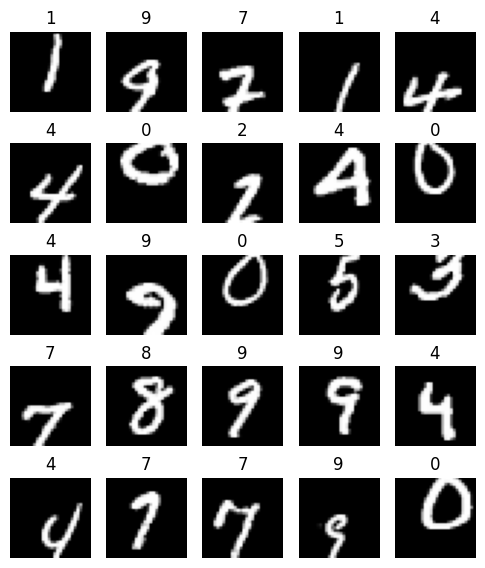

In [110]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_sh[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y_sh[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.225/0.211	Accuracy: 0.930/0.933

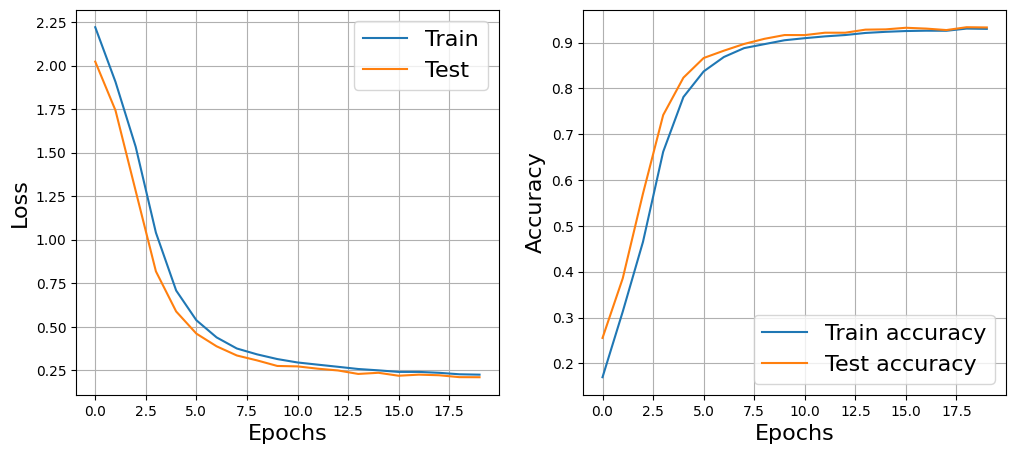

In [162]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_tg_sh, ts_tg_sh, tr_ac_tg_sh, ts_ac_tg_sh = train(network, 20, 0.01, plot=True, verbose=True, train_loader=train_loader_shift, test_loader=test_loader_shift)

##### Отдельно шум

In [112]:
import torch


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [125]:
transform_noise = transforms.Compose([
                       transforms.ToTensor(),
                       AddGaussianNoise(0.1, 0.2),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_noise = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset_noise = MNIST('.', train=False, transform=transform_noise)

train_loader_noise = DataLoader(train_dataset_noise, batch_size=32, shuffle=True)
test_loader_noise = DataLoader(test_dataset_noise, batch_size=32, shuffle=False)

In [126]:
X_n, y_n = next(iter(train_loader_noise))
X_n = X_n.numpy()
y_n = y_n.numpy()

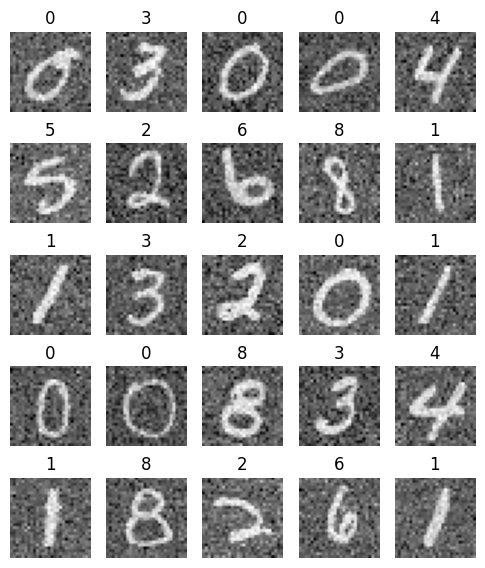

In [127]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_n[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y_n[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.065/0.095	Accuracy: 0.980/0.971

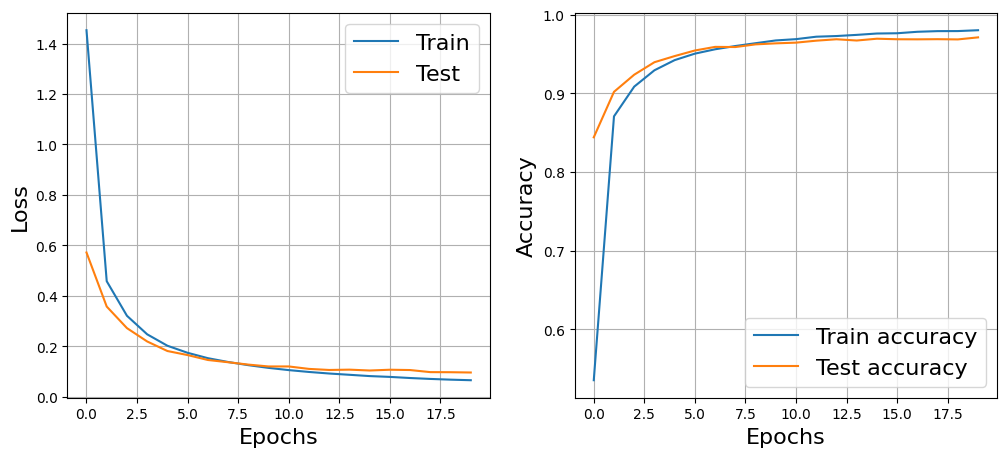

In [169]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_tg_n, ts_tg_n, tr_ac_tg_n, ts_ac_tg_n = train(network, 20, 0.01, plot=True, verbose=True, train_loader=train_loader_noise, test_loader=test_loader_noise)

### ВСЁ ВМЕСТЕ

In [152]:
transform_all = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomAffine(translate=(0.1, 0.3), degrees=0),
                       transforms.RandomRotation(degrees=(-15,15)),
                       AddGaussianNoise(0.1, 0.2),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_all = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset_all = MNIST('.', train=False, transform=transform_all)

train_loader_all = DataLoader(train_dataset_all, batch_size=32, shuffle=True)
test_loader_all = DataLoader(test_dataset_all, batch_size=32, shuffle=False)

In [153]:
X_all, y_all = next(iter(train_loader_all))
X_all = X_all.numpy()
y_all = y_all.numpy()

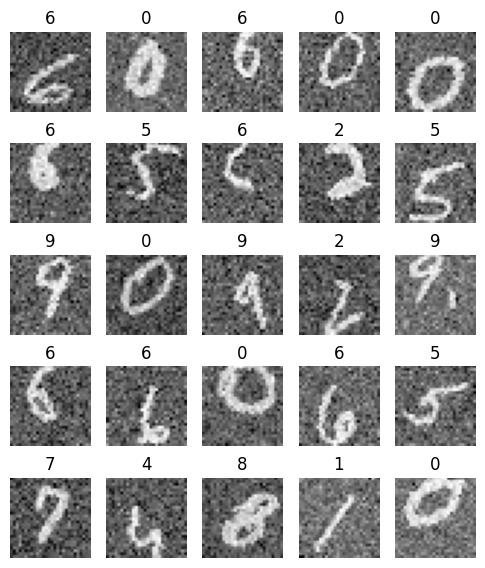

In [154]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_all[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y_all[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.406/0.386	Accuracy: 0.868/0.874

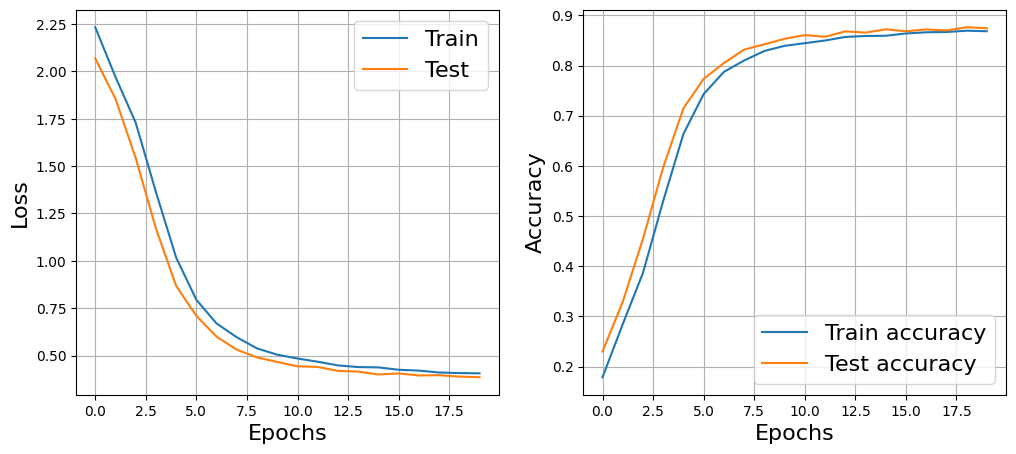

In [164]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_tg_all, ts_tg_all, tr_ac_tg_all, ts_ac_tg_all = train(network, 20, 0.01, plot=True, verbose=True, train_loader=train_loader_all, test_loader=test_loader_all)

In [156]:
transform_all2 = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomAffine(translate=(0.3, 0.6), degrees=0),
                       transforms.RandomRotation(degrees=(-40,40)),
                       AddGaussianNoise(0.2, 0.4),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_all2 = MNIST('.', train=True, download=True, transform=transform_all2)
test_dataset_all2 = MNIST('.', train=False, transform=transform_all2)

train_loader_all2 = DataLoader(train_dataset_all2, batch_size=32, shuffle=True)
test_loader_all2 = DataLoader(test_dataset_all2, batch_size=32, shuffle=False)

In [157]:
X_all2, y_all2 = next(iter(train_loader_all2))
X_all2 = X_all2.numpy()
y_all2 = y_all2.numpy()

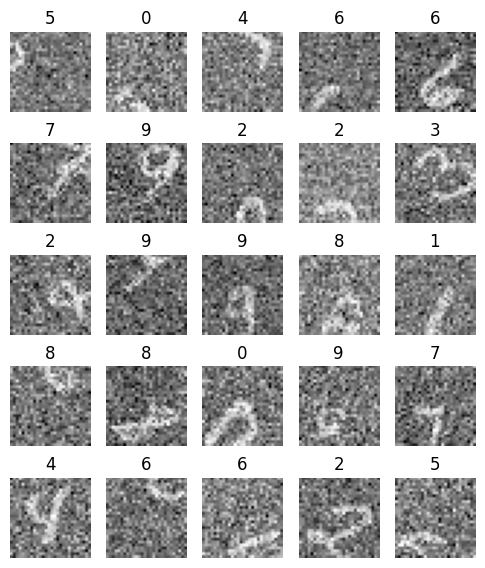

In [158]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_all2[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y_all2[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 1.967/1.946	Accuracy: 0.291/0.298

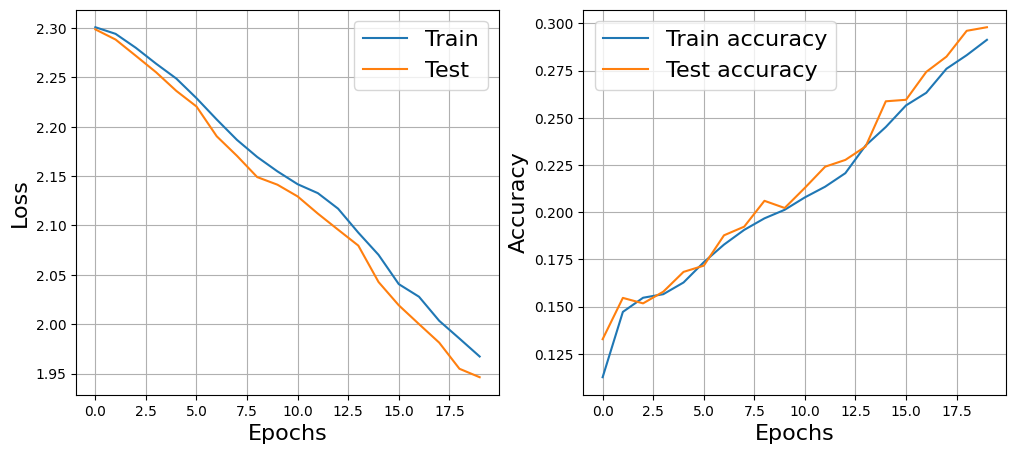

In [165]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_tg_all2, ts_tg_all2, tr_ac_tg_all2, ts_ac_tg_all2 = train(network, 20, 0.01, plot=True, verbose=True, train_loader=train_loader_all2, test_loader=test_loader_all2)

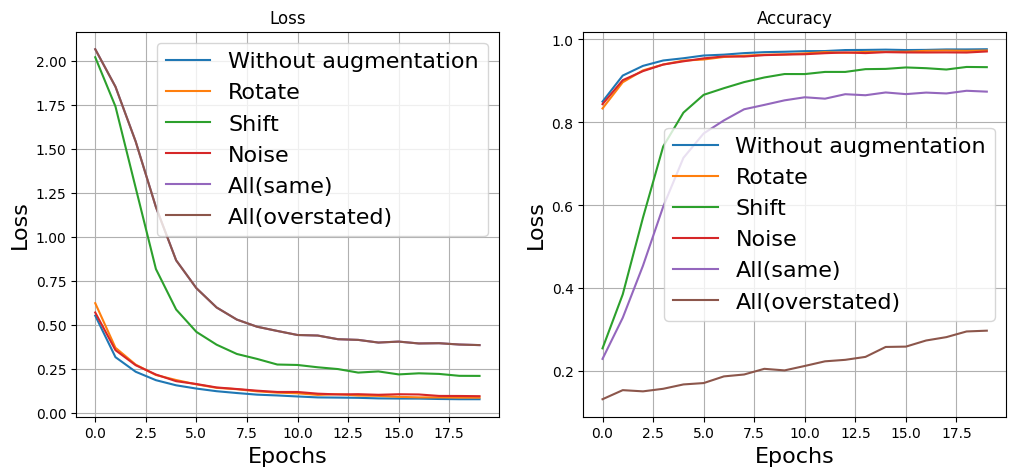

In [170]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_tg, label='Without augmentation')
plt.plot(ts_tg_rot, label='Rotate')
plt.plot(ts_tg_sh, label='Shift')
plt.plot(ts_tg_n, label='Noise')
plt.plot(ts_tg_all, label='All(same)')
plt.plot(ts_tg_all, label='All(overstated)')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_tg, label='Without augmentation')
plt.plot(ts_ac_tg_rot, label='Rotate')
plt.plot(ts_ac_tg_sh, label='Shift')
plt.plot(ts_ac_tg_n, label='Noise')
plt.plot(ts_ac_tg_all, label='All(same)')
plt.plot(ts_ac_tg_all2, label='All(overstated)')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

##### Мини-вывод
Из примененных агументаций шум показал себя лучше всего, но даже он оказался немного хуже версии без аугментации :(

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

****ОТВЕТ:****
Как мы можем увидеть выше, гиперболический тангенс (Tanh) показал себя лучше всего, а сигмоида (Sigmoid) хуже всех;
Аугментация не принесла значительного (даже обычного) роста точности. Во всех случаях рос лосс :(((
Однако на некоторых видах аугментации (shift, all) мы можем увидеть, что точность на тестовых данных выше, чем на трейновых.